   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 4.0 MB/s eta 0:00:00

    ╔══════════════════════════════════════════════════════════════════╗
    ║     SISTEMA DE PREPROCESAMIENTO DE DATOS DE ONGs                ║
    ╠══════════════════════════════════════════════════════════════════╣
    ║                                                                  ║
    ║  📝 INSTRUCCIONES DE USO:                                        ║
    ║                                                                  ║
    ║  1. Asegúrate de tener todos los archivos .docx en una carpeta  ║
    ║  2. Ejecuta la función principal:                                ║
    ║                                                                  ║
    ║     df = procesar_documentos_ongs('/ruta/a/tu/carpeta/')        ║
    ║                                                                  ║
    ║  3. Para Google Colab:                                          ║
    ║     df = procesar_documentos_ongs('/conten

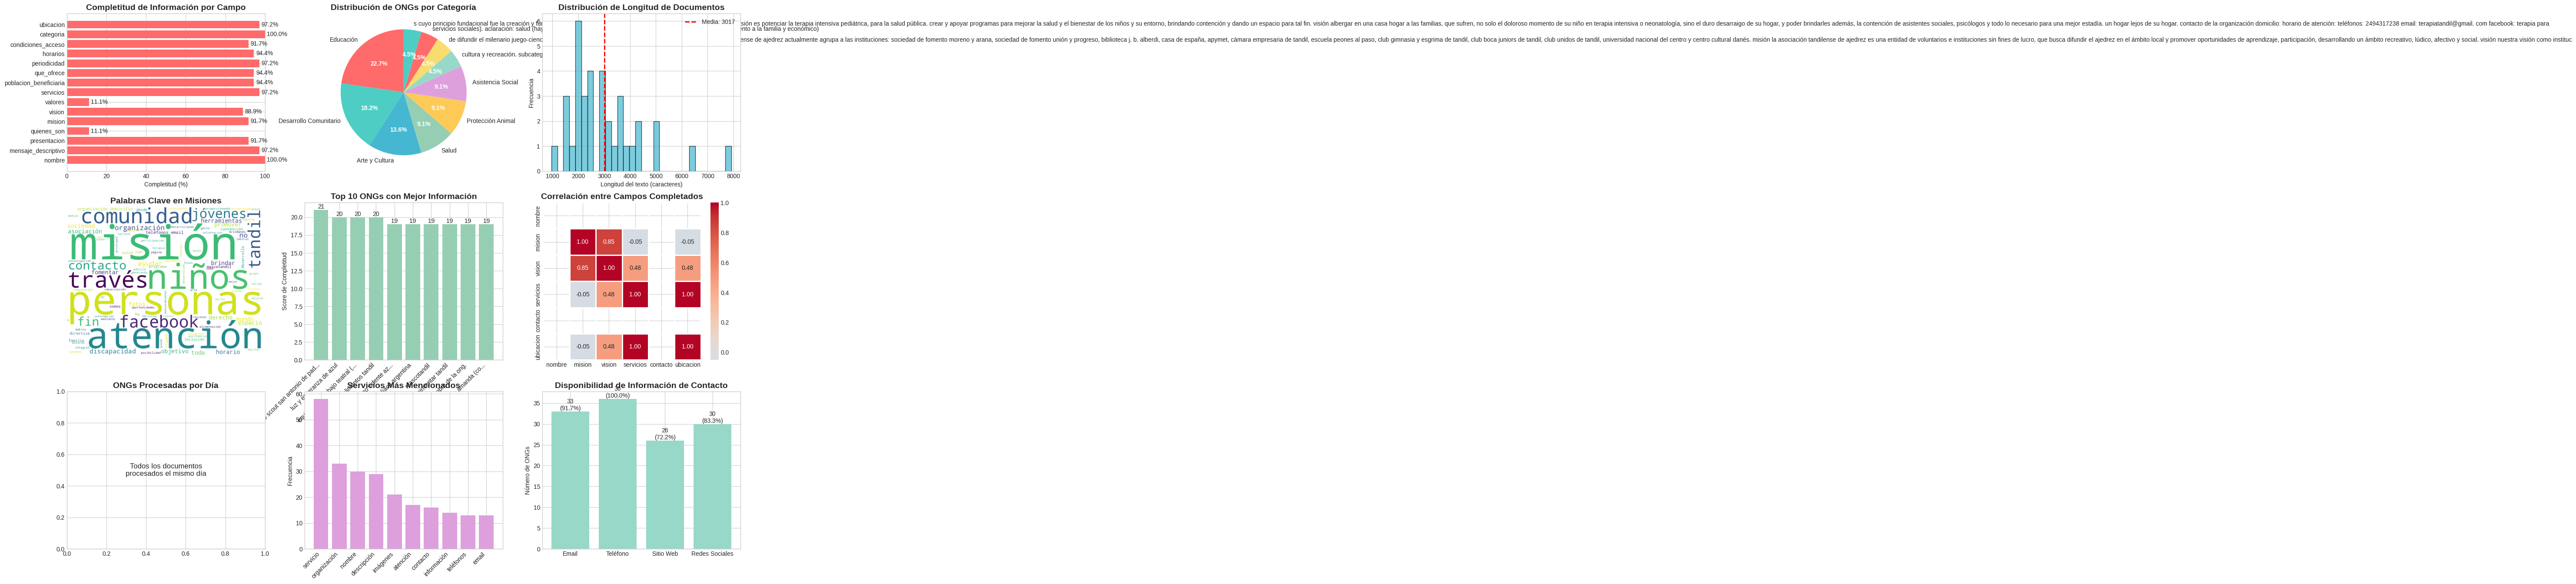


REPORTE DE ANÁLISIS DE ONGs

Fecha de generación: 2025-07-17 00:03:20

Total de ONGs procesadas: 36

📊 RESUMEN DE COMPLETITUD DE DATOS:
  - Nombre: 36/36 (100.0%)
  - Mision: 33/36 (91.7%)
  - Servicios: 35/36 (97.2%)
  - Contacto: 36/36 (100.0%)
  - Ubicacion: 35/36 (97.2%)

📂 CATEGORÍAS PRINCIPALES:
  - Educación: 5 ONGs (13.9%)
  - Desarrollo Comunitario: 4 ONGs (11.1%)
  - Arte y Cultura: 3 ONGs (8.3%)
  - Salud: 2 ONGs (5.6%)
  - Protección Animal: 2 ONGs (5.6%)

🏆 ONGs CON INFORMACIÓN MÁS COMPLETA:
  - grupo scout san antonio de padua tandil (Score: 21, Categoría: educación e investigación sub-categoría: otra educación (educación no formal))
  - luz y esperanza de azul (Score: 20, Categoría: Asistencia Social)
  - equipo delta-trabajo teatral (azul) (Score: 20, Categoría: Arte y Cultura)
  - banco de alimentos tandil (Score: 20, Categoría: puesto en marcha en nuestro país. se inauguro públicamente el 18 de mayo de 2002. frente al aumento de la pobreza que provocó la crisis del 2

In [1]:
# Sistema Mejorado de Preprocesamiento de Datos de ONGs
# Proyecto: Sistema de Recomendación de ONGs con IA

# ============================================================================
# INSTALACIÓN (para Google Colab)
# ============================================================================
!pip install python-docx pandas matplotlib seaborn wordcloud nltk openpyxl scikit-learn

# ============================================================================
# IMPORTACIONES
# ============================================================================
import pandas as pd
import numpy as np
import re
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from collections import Counter
from docx import Document
import warnings
from datetime import datetime
import json
from typing import Dict, List, Optional, Tuple
import logging

warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURACIÓN
# ============================================================================

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Descargar recursos de NLTK
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt_tab', quiet=True)
except:
    pass

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Palabras vacías en español para nubes de palabras
PALABRAS_VACIAS_ES = {
    'de', 'la', 'el', 'en', 'y', 'a', 'que', 'es', 'se', 'del', 'los', 'un',
    'por', 'con', 'las', 'al', 'lo', 'como', 'más', 'o', 'pero', 'sus', 'le',
    'ha', 'me', 'si', 'sin', 'sobre', 'este', 'ya', 'todo', 'esta', 'su',
    'hacer', 'son', 'dos', 'puede', 'tiempo', 'muy', 'cuando', 'uno', 'hasta',
    'donde', 'mismo', 'ella', 'nos', 'durante', 'todos', 'uno', 'les', 'ni',
    'contra', 'otros', 'para', 'nuestra', 'nuestro', 'nuestros', 'nuestras',
    'una', 'ser', 'sido', 'era', 'estar', 'tiene', 'entre', 'fue', 'había',
    'también', 'así', 'aunque', 'bien', 'cual', 'hace', 'cada', 'año', 'años'
}

# ============================================================================
# CLASE PRINCIPAL PARA EXTRACCIÓN DE DATOS
# ============================================================================

class ExtractorDatosONG:
    """Clase para extraer y procesar datos de ONGs desde documentos"""

    def __init__(self):
        self.patrones_campos = self._inicializar_patrones()
        self.estadisticas_extraccion = {'exitosas': 0, 'fallidas': 0, 'parciales': 0}
        self.categorias_predefinidas = [
            'Salud', 'Educación', 'Medio Ambiente', 'Derechos Humanos',
            'Desarrollo Comunitario', 'Arte y Cultura', 'Deportes',
            'Asistencia Social', 'Protección Animal', 'Desarrollo Económico'
        ]

    def _inicializar_patrones(self) -> Dict[str, List[str]]:
        """Inicializar patrones regex para extracción de campos"""
        return {
            'nombre': [
                r'nombre\s*(?:de\s*la\s*)?(?:ong|organizaci[óo]n)?:?\s*(.+?)(?:\n|$)',
                r'^([A-Z][A-Za-zÁÉÍÓÚáéíóúñÑ\s\-\.]+?)(?:\n|mensaje|presentaci)',
                r'organizaci[óo]n\s*:?\s*(.+?)(?:\n|$)',
                r'instituci[óo]n\s*:?\s*(.+?)(?:\n|$)'
            ],
            'mensaje_descriptivo': [
                r'mensaje\s*descriptivo:?\s*(.+?)(?:\n\s*\n|\npresentaci)',
                r'descripci[óo]n\s*(?:breve)?:?\s*(.+?)(?:\n\s*\n|\nquienes)',
                r'resumen:?\s*(.+?)(?:\n\s*\n|\npresentaci)',
                r'introducci[óo]n:?\s*(.+?)(?:\n\s*\n|\nquienes)'
            ],
            'presentacion': [
                r'presentaci[óo]n(?:\s*de\s*la\s*ong)?:?\s*(.+?)(?:\n\s*\n|\nquienes|\nmisi)',
                r'acerca\s*de\s*nosotros:?\s*(.+?)(?:\n\s*\n|\nquienes)',
                r'historia:?\s*(.+?)(?:\n\s*\n|\nmisi)'
            ],
            'quienes_son': [
                r'(?:qui[éeÉE]nes?\s*(?:son|somos))|(?:quienes\s*somos):?\s*(.+?)(?:\n\s*\n|\nmisi|\nvisi)',
                r'nosotros:?\s*(.+?)(?:\n\s*\n|\nmisi)',
                r'equipo:?\s*(.+?)(?:\n\s*\n|\nmisi)'
            ],
            'mision': [
                r'misi[óoÓO]n:?\s*(.+?)(?:\n\s*\n|\nvisi|\nvalores|\nservici)',
                r'nuestra\s*misi[óo]n:?\s*(.+?)(?:\n\s*\n|\nvisi)',
                r'prop[óo]sito:?\s*(.+?)(?:\n\s*\n|\nvisi)'
            ],
            'vision': [
                r'visi[óoÓO]n:?\s*(.+?)(?:\n\s*\n|\nservici|\nvalores|\npoblaci)',
                r'nuestra\s*visi[óo]n:?\s*(.+?)(?:\n\s*\n|\nservici)',
                r'futuro:?\s*(.+?)(?:\n\s*\n|\nservici)'
            ],
            'valores': [
                r'valores:?\s*(.+?)(?:\n\s*\n|\nservici|\nmisi)',
                r'principios:?\s*(.+?)(?:\n\s*\n|\nservici)',
                r'creencias:?\s*(.+?)(?:\n\s*\n|\nservici)'
            ],
            'servicios': [
                r'servicios?(?:\s*que\s*ofrecemos)?:?\s*(.+?)(?:\n\s*\n|\npoblaci|\nbeneficiari)',
                r'(?:programas?\s*y\s*)?servicios:?\s*(.+?)(?:\n\s*\n|\npoblaci)',
                r'actividades:?\s*(.+?)(?:\n\s*\n|\npoblaci)',
                r'proyectos:?\s*(.+?)(?:\n\s*\n|\npoblaci)'
            ],
            'poblacion_beneficiaria': [
                r'poblaci[óo]n\s*(?:beneficiaria|objetivo):?\s*(.+?)(?:\n\s*\n|\nque\s*ofrece|\nperiodicidad)',
                r'beneficiarios?:?\s*(.+?)(?:\n\s*\n|\nque\s*ofrece)',
                r'dirigido\s*a:?\s*(.+?)(?:\n\s*\n|\nperiodicidad)',
                r'p[úu]blico\s*objetivo:?\s*(.+?)(?:\n\s*\n|\nperiodicidad)'
            ],
            'que_ofrece': [
                r'qu[éeÉE]\s*ofrece(?:mos)?:?\s*(.+?)(?:\n\s*\n|\nperiodicidad|\nhorari)',
                r'ofrecemos:?\s*(.+?)(?:\n\s*\n|\nperiodicidad)',
                r'brindamos:?\s*(.+?)(?:\n\s*\n|\nperiodicidad)'
            ],
            'periodicidad': [
                r'periodicidad:?\s*(.+?)(?:\n\s*\n|\nhorari|\ncondici)',
                r'frecuencia:?\s*(.+?)(?:\n\s*\n|\nhorari)',
                r'cu[áa]ndo:?\s*(.+?)(?:\n\s*\n|\nhorari)'
            ],
            'horarios': [
                r'horarios?\s*(?:de\s*atenci[óo]n)?:?\s*(.+?)(?:\n\s*\n|\ncondici|\ncategor)',
                r'atenci[óo]n:?\s*(.+?)(?:\n\s*\n|\ncondici)',
                r'disponibilidad:?\s*(.+?)(?:\n\s*\n|\ncondici)'
            ],
            'condiciones_acceso': [
                r'condici(?:ones)?\s*(?:de\s*)?acceso:?\s*(.+?)(?:\n\s*\n|\ncategor|\nubicaci)',
                r'requisitos:?\s*(.+?)(?:\n\s*\n|\ncategor)',
                r'c[óo]mo\s*acceder:?\s*(.+?)(?:\n\s*\n|\ncategor)'
            ],
            'categoria': [
                r'categor[íi]a:?\s*(.+?)(?:\n\s*\n|\nubicaci|\ncontact)',
                r'tipo\s*(?:de\s*organizaci[óo]n)?:?\s*(.+?)(?:\n\s*\n|\nubicaci)',
                r'[áa]rea\s*(?:de\s*trabajo)?:?\s*(.+?)(?:\n\s*\n|\nubicaci)'
            ],
            'ubicacion': [
                r'ubicaci[óo]n:?\s*(.+?)(?:\n\s*\n|\ncontact|\ntel[éeÉE]fono)',
                r'direcci[óo]n:?\s*(.+?)(?:\n\s*\n|\ncontact)',
                r'(?:d[óo]nde\s*)?(?:estamos|encontrarnos):?\s*(.+?)(?:\n\s*\n|\ncontact)',
                r'sede:?\s*(.+?)(?:\n\s*\n|\ncontact)'
            ],
            'contacto': [
                r'contacto?s?:?\s*(.+?)(?:\n\s*\n|\nencargad|\nresponsable|$)',
                r'tel[éeÉE]fonos?:?\s*(.+?)(?:\n\s*\n|\nemail)',
                r'(?:correo\s*)?(?:electr[óo]nico|email):?\s*(.+?)(?:\n\s*\n|\nencargad|$)',
                r'whatsapp:?\s*(.+?)(?:\n\s*\n|\nencargad|$)'
            ],
            'encargado': [
                r'encargad[oa]s?:?\s*(.+?)(?:\n\s*\n|$)',
                r'responsables?:?\s*(.+?)(?:\n\s*\n|$)',
                r'coordinador(?:es)?:?\s*(.+?)(?:\n\s*\n|$)',
                r'director(?:es)?:?\s*(.+?)(?:\n\s*\n|$)'
            ],
            'sitio_web': [
                r'(?:sitio\s*)?web:?\s*(.+?)(?:\n\s*\n|$)',
                r'p[áa]gina\s*web:?\s*(.+?)(?:\n\s*\n|$)',
                r'website:?\s*(.+?)(?:\n\s*\n|$)',
                r'(?:www\.|https?://)[^\s\n]+',
            ],
            'redes_sociales': [
                r'redes\s*sociales:?\s*(.+?)(?:\n\s*\n|$)',
                r'facebook:?\s*(.+?)(?:\n\s*\n|$)',
                r'instagram:?\s*(.+?)(?:\n\s*\n|$)',
                r's[íi]guenos:?\s*(.+?)(?:\n\s*\n|$)'
            ]
        }

    def extraer_texto_docx(self, ruta_archivo: Path) -> str:
        """Extraer texto de un archivo .docx con manejo mejorado de errores"""
        try:
            doc = Document(ruta_archivo)
            parrafos = []

            # Extraer párrafos
            for parrafo in doc.paragraphs:
                texto = parrafo.text.strip()
                if texto:
                    parrafos.append(texto)

            # Extraer texto de tablas
            for tabla in doc.tables:
                for fila in tabla.rows:
                    for celda in fila.cells:
                        texto_celda = celda.text.strip()
                        if texto_celda and texto_celda not in parrafos:
                            parrafos.append(texto_celda)

            # Extraer texto de encabezados y pies de página si es posible
            try:
                for seccion in doc.sections:
                    encabezado = seccion.header
                    pie = seccion.footer

                    for parrafo in encabezado.paragraphs:
                        texto = parrafo.text.strip()
                        if texto and texto not in parrafos:
                            parrafos.append(texto)

                    for parrafo in pie.paragraphs:
                        texto = parrafo.text.strip()
                        if texto and texto not in parrafos:
                            parrafos.append(texto)
            except:
                pass

            return '\n'.join(parrafos)

        except Exception as e:
            logger.error(f"Error procesando {ruta_archivo}: {str(e)}")
            return ""

    def limpiar_texto(self, texto: str) -> str:
        """Limpieza mejorada de texto"""
        if not texto or pd.isna(texto):
            return ""

        texto = str(texto).strip()

        # Normalizar espacios en blanco
        texto = re.sub(r'\s+', ' ', texto)

        # Eliminar caracteres no imprimibles pero mantener caracteres españoles
        texto = re.sub(r'[^\w\s\-.,;:()¿?¡!áéíóúüñÁÉÍÓÚÜÑ@/#]', '', texto)

        # Eliminar puntuación múltiple
        texto = re.sub(r'([.,:;])\1+', r'\1', texto)

        # Corregir espacios alrededor de puntuación
        texto = re.sub(r'\s+([.,;:])', r'\1', texto)
        texto = re.sub(r'([.,;:])\s*', r'\1 ', texto)

        # Recortar longitud excesiva
        if len(texto) > 1000:
            texto = texto[:997] + "..."

        return texto.strip()

    def extraer_campo(self, texto: str, campo: str) -> str:
        """Extraer un campo específico del texto usando patrones regex"""
        texto_lower = texto.lower()

        for patron in self.patrones_campos.get(campo, []):
            coincidencia = re.search(patron, texto_lower, re.DOTALL | re.IGNORECASE)
            if coincidencia:
              try:
                  extraido = coincidencia.group(1)
                  if extraido:
                      extraido = extraido.strip()
                      if len(extraido) > 2:
                          return self.limpiar_texto(extraido[:800])
              except IndexError:
                  continue  # patrón sin grupo de captura

        return ""

    def detectar_categoria(self, texto_completo: str) -> str:
        """Detectar automáticamente la categoría de la ONG basándose en palabras clave"""
        texto_lower = texto_completo.lower()

        palabras_clave_categoria = {
            'Salud': ['salud', 'médico', 'hospital', 'clínica', 'enfermedad', 'tratamiento',
                     'paciente', 'medicina', 'terapia', 'rehabilitación'],
            'Educación': ['educación', 'escuela', 'estudiante', 'enseñanza', 'aprendizaje',
                         'capacitación', 'formación', 'taller', 'curso', 'beca'],
            'Medio Ambiente': ['ambiente', 'ecología', 'sostenible', 'reciclaje', 'naturaleza',
                              'conservación', 'biodiversidad', 'clima', 'verde', 'sustentable'],
            'Derechos Humanos': ['derechos', 'humanos', 'justicia', 'igualdad', 'libertad',
                                'dignidad', 'protección', 'vulnerables', 'discriminación'],
            'Desarrollo Comunitario': ['comunidad', 'barrio', 'vecinos', 'desarrollo', 'social',
                                      'participación', 'mejora', 'calidad de vida', 'bienestar'],
            'Arte y Cultura': ['arte', 'cultura', 'música', 'teatro', 'danza', 'pintura',
                              'expresión', 'creatividad', 'patrimonio', 'tradición'],
            'Deportes': ['deporte', 'fútbol', 'básquet', 'natación', 'atletismo', 'ejercicio',
                        'actividad física', 'recreación', 'competencia', 'entrenamiento'],
            'Asistencia Social': ['asistencia', 'ayuda', 'apoyo', 'alimentación', 'comedor',
                                 'refugio', 'emergencia', 'necesidad', 'vulnerable', 'pobreza'],
            'Protección Animal': ['animal', 'mascota', 'perro', 'gato', 'refugio', 'adopción',
                                 'veterinario', 'bienestar animal', 'rescate', 'fauna'],
            'Desarrollo Económico': ['económico', 'emprendimiento', 'microcrédito', 'negocio',
                                    'empleo', 'capacitación laboral', 'productivo', 'ingreso']
        }

        puntuaciones_categoria = {}

        for categoria, palabras_clave in palabras_clave_categoria.items():
            puntuacion = sum(1 for palabra in palabras_clave if palabra in texto_lower)
            if puntuacion > 0:
                puntuaciones_categoria[categoria] = puntuacion

        if puntuaciones_categoria:
            return max(puntuaciones_categoria, key=puntuaciones_categoria.get)

        return "Sin categorizar"

    def validar_email(self, texto: str) -> str:
        """Extraer y validar direcciones de email"""
        patron_email = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
        emails = re.findall(patron_email, texto)
        return ', '.join(emails) if emails else ""

    def validar_telefono(self, texto: str) -> str:
        """Extraer y validar números de teléfono"""
        # Patrones para números de teléfono en varios formatos
        patrones_telefono = [
            r'\+?\d{1,3}[-.\s]?\(?\d{1,4}\)?[-.\s]?\d{1,4}[-.\s]?\d{1,4}[-.\s]?\d{0,4}',
            r'\b\d{4}[-.\s]?\d{4}\b',
            r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b'
        ]

        telefonos = []
        for patron in patrones_telefono:
            encontrados = re.findall(patron, texto)
            telefonos.extend(encontrados)

        # Eliminar duplicados y formatear
        telefonos_unicos = list(set(telefonos))
        return ', '.join(telefonos_unicos[:3])  # Máximo 3 números

    def extraer_url(self, texto: str) -> str:
        """Extraer URLs del texto"""
        patron_url = r'https?://(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&/=]*)'
        urls = re.findall(patron_url, texto)
        return ', '.join(urls[:2]) if urls else ""  # Máximo 2 URLs

    def parsear_documento_ong(self, texto: str, nombre_archivo: str) -> Dict[str, str]:
        """Parsear un documento de ONG y extraer información estructurada"""
        datos_ong = {
            'nombre': '',
            'mensaje_descriptivo': '',
            'presentacion': '',
            'quienes_son': '',
            'mision': '',
            'vision': '',
            'valores': '',
            'servicios': '',
            'poblacion_beneficiaria': '',
            'que_ofrece': '',
            'periodicidad': '',
            'horarios': '',
            'condiciones_acceso': '',
            'categoria': '',
            'ubicacion': '',
            'contacto': '',
            'encargado': '',
            'sitio_web': '',
            'redes_sociales': '',
            'email': '',
            'telefono': '',
            'archivo_fuente': nombre_archivo,
            'fecha_procesamiento': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'texto_completo': texto
        }

        # Extraer campos usando patrones
        for campo in self.patrones_campos.keys():
            datos_ong[campo] = self.extraer_campo(texto, campo)

        # Validaciones y extracciones especiales
        datos_ong['email'] = self.validar_email(texto)
        datos_ong['telefono'] = self.validar_telefono(texto)

        # Si no se encontró sitio web en el campo específico, buscar URLs
        if not datos_ong['sitio_web']:
            datos_ong['sitio_web'] = self.extraer_url(texto)

        # Detectar categoría si no se encontró
        if not datos_ong['categoria']:
            datos_ong['categoria'] = self.detectar_categoria(texto)

        # Calcular completitud del documento
        campos_importantes = ['nombre', 'mision', 'servicios', 'contacto', 'ubicacion']
        campos_llenos = sum(1 for campo in campos_importantes if datos_ong[campo])

        if campos_llenos >= 4:
            self.estadisticas_extraccion['exitosas'] += 1
        elif campos_llenos >= 2:
            self.estadisticas_extraccion['parciales'] += 1
        else:
            self.estadisticas_extraccion['fallidas'] += 1

        return datos_ong

# ============================================================================
# FUNCIONES DE PROCESAMIENTO Y ANÁLISIS
# ============================================================================

class AnalizadorDatosONG:
    """Clase para analizar y visualizar datos de ONGs"""

    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.reporte = {}

    def analizar_calidad_datos(self) -> pd.DataFrame:
        """Analizar la calidad de los datos extraídos"""
        print("🔍 ANÁLISIS DE CALIDAD DE DATOS")
        print("=" * 60)

        # Información general
        print(f"📊 Total de ONGs procesadas: {len(self.df)}")
        print(f"📊 Total de campos: {len(self.df.columns)}")

        # Completitud por campo
        completitud = {}
        for col in self.df.columns:
            if col not in ['archivo_fuente', 'texto_completo', 'fecha_procesamiento']:
                # Verificar que no sean nulos y que al convertir a string no estén vacíos
                no_vacios = self.df[col].notna() & (self.df[col].astype(str).str.strip() != '')
                completitud[col] = (no_vacios.sum() / len(self.df)) * 100

        completitud_df = pd.DataFrame(list(completitud.items()),
                                    columns=['Campo', 'Completitud (%)'])
        completitud_df = completitud_df.sort_values('Completitud (%)', ascending=False)

        print("\n📈 COMPLETITUD POR CAMPO:")
        print(completitud_df.to_string(index=False))

        # Estadísticas de longitud de texto
        print(f"\n📏 ESTADÍSTICAS DE LONGITUD DE TEXTO:")
        longitudes_texto = self.df['texto_completo'].str.len()
        print(f"Longitud promedio: {longitudes_texto.mean():.0f} caracteres")
        print(f"Longitud mínima: {longitudes_texto.min():.0f} caracteres")
        print(f"Longitud máxima: {longitudes_texto.max():.0f} caracteres")
        print(f"Desviación estándar: {longitudes_texto.std():.0f} caracteres")

        # Análisis de categorías
        print(f"\n📂 DISTRIBUCIÓN POR CATEGORÍAS:")
        categorias = self.df['categoria'].value_counts()
        for cat, count in categorias.items():
            print(f"  {cat}: {count} ({count/len(self.df)*100:.1f}%)")

        self.reporte['completitud'] = completitud_df
        self.reporte['categorias'] = categorias

        return completitud_df

    def generar_estadisticas_avanzadas(self):
        """Generar estadísticas avanzadas sobre los datos"""
        print("\n📊 ESTADÍSTICAS AVANZADAS")
        print("=" * 60)

        # ONGs con información más completa
        self.df['completitud_score'] = self.df.apply(
            lambda row: sum(1 for col in self.df.columns
                          if col not in ['archivo_fuente', 'texto_completo', 'fecha_procesamiento', 'completitud_score']
                          and pd.notna(row[col]) and str(row[col]).strip() != ''),
            axis=1
        )

        top_ongs = self.df.nlargest(5, 'completitud_score')[['nombre', 'completitud_score', 'categoria']]
        print("\n🏆 TOP 5 ONGs CON MEJOR INFORMACIÓN:")
        print(top_ongs.to_string(index=False))

        # Análisis de servicios más comunes
        print("\n🔧 SERVICIOS MÁS MENCIONADOS:")
        todos_servicios = ' '.join(self.df['servicios'].dropna())
        palabras_servicios = re.findall(r'\b\w+\b', todos_servicios.lower())
        servicios_comunes = Counter(palabra for palabra in palabras_servicios
                                  if len(palabra) > 4 and palabra not in PALABRAS_VACIAS_ES)

        for servicio, frecuencia in servicios_comunes.most_common(10):
            print(f"  {servicio}: {frecuencia} menciones")

        # Análisis de población beneficiaria
        print("\n👥 POBLACIÓN BENEFICIARIA MÁS MENCIONADA:")
        todas_poblaciones = ' '.join(self.df['poblacion_beneficiaria'].dropna())
        poblaciones_keywords = ['niños', 'niñas', 'jóvenes', 'adultos', 'mayores',
                               'mujeres', 'familias', 'comunidad', 'estudiantes']

        for keyword in poblaciones_keywords:
            count = todas_poblaciones.lower().count(keyword)
            if count > 0:
                print(f"  {keyword.capitalize()}: {count} menciones")

    def crear_visualizaciones(self, guardar_imagenes: bool = True):
        """Crear visualizaciones mejoradas de los datos"""
        # Configurar el estilo
        plt.style.use('seaborn-v0_8-whitegrid')
        colores = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#DDA0DD', '#98D8C8', '#F7DC6F']

        # Crear figura con subgráficos
        fig = plt.figure(figsize=(20, 16))

        # 1. Completitud por campo (gráfico de barras horizontal)
        ax1 = plt.subplot(3, 3, 1)
        completitud = {}
        for col in self.df.columns:
            if col not in ['archivo_fuente', 'texto_completo', 'fecha_procesamiento', 'completitud_score']:
                # Verificar valores no nulos y no vacíos
                no_vacios = self.df[col].notna() & (self.df[col].astype(str).str.strip() != '')
                completitud[col] = (no_vacios.sum() / len(self.df)) * 100

        campos = list(completitud.keys())[:15]
        valores = [completitud[f] for f in campos]

        bars = ax1.barh(campos, valores, color=colores[0])
        ax1.set_xlabel('Completitud (%)')
        ax1.set_title('Completitud de Información por Campo', fontsize=14, fontweight='bold')
        ax1.set_xlim(0, 100)

        # Añadir valores en las barras
        for i, (bar, valor) in enumerate(zip(bars, valores)):
            ax1.text(valor + 1, i, f'{valor:.1f}%', va='center')

        # 2. Distribución de categorías (gráfico de pastel)
        ax2 = plt.subplot(3, 3, 2)
        categorias = self.df['categoria'].value_counts().head(10)
        if not categorias.empty:
            wedges, texts, autotexts = ax2.pie(categorias.values,
                                               labels=categorias.index,
                                               autopct='%1.1f%%',
                                               colors=colores[:len(categorias)],
                                               startangle=90)
            ax2.set_title('Distribución de ONGs por Categoría', fontsize=14, fontweight='bold')

            # Mejorar legibilidad
            for text in texts:
                text.set_fontsize(10)
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')

        # 3. Distribución de longitud de documentos
        ax3 = plt.subplot(3, 3, 3)
        longitudes = self.df['texto_completo'].str.len()
        ax3.hist(longitudes, bins=30, color=colores[2], alpha=0.7, edgecolor='black')
        ax3.axvline(longitudes.mean(), color='red', linestyle='dashed', linewidth=2, label=f'Media: {longitudes.mean():.0f}')
        ax3.set_xlabel('Longitud del texto (caracteres)')
        ax3.set_ylabel('Frecuencia')
        ax3.set_title('Distribución de Longitud de Documentos', fontsize=14, fontweight='bold')
        ax3.legend()

        # 4. Nube de palabras de misiones
        ax4 = plt.subplot(3, 3, 4)
        texto_misiones = ' '.join(self.df['mision'].dropna().astype(str))
        if texto_misiones.strip():
            wordcloud = WordCloud(width=800, height=600,
                                background_color='white',
                                stopwords=PALABRAS_VACIAS_ES,
                                colormap='viridis',
                                max_words=100).generate(texto_misiones)
            ax4.imshow(wordcloud, interpolation='bilinear')
            ax4.axis('off')
            ax4.set_title('Palabras Clave en Misiones', fontsize=14, fontweight='bold')

        # 5. Top 10 ONGs por completitud
        ax5 = plt.subplot(3, 3, 5)
        top_ongs = self.df.nlargest(10, 'completitud_score')[['nombre', 'completitud_score']]
        nombres_cortos = [nombre[:30] + '...' if len(str(nombre)) > 30 else str(nombre)
                         for nombre in top_ongs['nombre']]

        bars = ax5.bar(range(len(nombres_cortos)), top_ongs['completitud_score'], color=colores[3])
        ax5.set_xticks(range(len(nombres_cortos)))
        ax5.set_xticklabels(nombres_cortos, rotation=45, ha='right')
        ax5.set_ylabel('Score de Completitud')
        ax5.set_title('Top 10 ONGs con Mejor Información', fontsize=14, fontweight='bold')

        # Añadir valores en las barras
        for bar in bars:
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')

        # 6. Matriz de correlación de campos completados
        ax6 = plt.subplot(3, 3, 6)
        campos_binarios = pd.DataFrame()
        for col in ['nombre', 'mision', 'vision', 'servicios', 'contacto', 'ubicacion']:
            if col in self.df.columns:
                campos_binarios[col] = (self.df[col].notna() & (self.df[col] != '')).astype(int)

        if not campos_binarios.empty:
            corr_matrix = campos_binarios.corr()
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                       square=True, linewidths=1, ax=ax6, fmt='.2f')
            ax6.set_title('Correlación entre Campos Completados', fontsize=14, fontweight='bold')

        # 7. Análisis temporal (si hay múltiples fechas de procesamiento)
        ax7 = plt.subplot(3, 3, 7)
        if 'fecha_procesamiento' in self.df.columns:
            try:
                self.df['fecha'] = pd.to_datetime(self.df['fecha_procesamiento'])
                procesamiento_por_dia = self.df.groupby(self.df['fecha'].dt.date).size()

                if len(procesamiento_por_dia) > 1:
                    ax7.plot(procesamiento_por_dia.index, procesamiento_por_dia.values,
                            marker='o', color=colores[4], linewidth=2)
                    ax7.set_xlabel('Fecha')
                    ax7.set_ylabel('Número de ONGs procesadas')
                    ax7.set_title('ONGs Procesadas por Día', fontsize=14, fontweight='bold')
                    ax7.tick_params(axis='x', rotation=45)
                else:
                    ax7.text(0.5, 0.5, 'Todos los documentos\nprocesados el mismo día',
                            ha='center', va='center', fontsize=12)
                    ax7.set_title('ONGs Procesadas por Día', fontsize=14, fontweight='bold')
            except:
                ax7.text(0.5, 0.5, 'Sin datos temporales', ha='center', va='center')

        # 8. Servicios más mencionados
        ax8 = plt.subplot(3, 3, 8)
        todos_servicios = ' '.join(self.df['servicios'].dropna())
        palabras_servicios = re.findall(r'\b\w+\b', todos_servicios.lower())
        servicios_comunes = Counter(palabra for palabra in palabras_servicios
                                  if len(palabra) > 4 and palabra not in PALABRAS_VACIAS_ES)

        top_servicios = dict(servicios_comunes.most_common(10))
        if top_servicios:
            bars = ax8.bar(range(len(top_servicios)), list(top_servicios.values()), color=colores[5])
            ax8.set_xticks(range(len(top_servicios)))
            ax8.set_xticklabels(list(top_servicios.keys()), rotation=45, ha='right')
            ax8.set_ylabel('Frecuencia')
            ax8.set_title('Servicios Más Mencionados', fontsize=14, fontweight='bold')

        # 9. Análisis de contacto
        ax9 = plt.subplot(3, 3, 9)
        tiene_email = (self.df['email'].notna() & (self.df['email'] != '')).sum()
        tiene_telefono = (self.df['telefono'].notna() & (self.df['telefono'] != '')).sum()
        tiene_web = (self.df['sitio_web'].notna() & (self.df['sitio_web'] != '')).sum()
        tiene_redes = (self.df['redes_sociales'].notna() & (self.df['redes_sociales'] != '')).sum()

        contacto_data = {
            'Email': tiene_email,
            'Teléfono': tiene_telefono,
            'Sitio Web': tiene_web,
            'Redes Sociales': tiene_redes
        }

        bars = ax9.bar(contacto_data.keys(), contacto_data.values(), color=colores[6])
        ax9.set_ylabel('Número de ONGs')
        ax9.set_title('Disponibilidad de Información de Contacto', fontsize=14, fontweight='bold')

        # Añadir porcentajes
        for bar in bars:
            height = bar.get_height()
            ax9.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}\n({height/len(self.df)*100:.1f}%)',
                    ha='center', va='bottom')

        plt.tight_layout()

        if guardar_imagenes:
            plt.savefig('analisis_ongs_completo.png', dpi=300, bbox_inches='tight')
            print("✅ Visualizaciones guardadas en 'analisis_ongs_completo.png'")

        plt.show()

    def generar_reporte_resumen(self) -> str:
        """Generar un reporte de resumen en texto"""
        reporte = []
        reporte.append("=" * 80)
        reporte.append("REPORTE DE ANÁLISIS DE ONGs")
        reporte.append("=" * 80)
        reporte.append(f"\nFecha de generación: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        reporte.append(f"\nTotal de ONGs procesadas: {len(self.df)}")

        # Resumen de completitud
        reporte.append("\n📊 RESUMEN DE COMPLETITUD DE DATOS:")
        campos_criticos = ['nombre', 'mision', 'servicios', 'contacto', 'ubicacion']
        for campo in campos_criticos:
            if campo in self.df.columns:
                completitud = (self.df[campo].notna() & (self.df[campo] != '')).sum()
                porcentaje = completitud / len(self.df) * 100
                reporte.append(f"  - {campo.capitalize()}: {completitud}/{len(self.df)} ({porcentaje:.1f}%)")

        # Categorías principales
        reporte.append("\n📂 CATEGORÍAS PRINCIPALES:")
        categorias = self.df['categoria'].value_counts().head(5)
        for cat, count in categorias.items():
            reporte.append(f"  - {cat}: {count} ONGs ({count/len(self.df)*100:.1f}%)")

        # ONGs destacadas
        reporte.append("\n🏆 ONGs CON INFORMACIÓN MÁS COMPLETA:")
        top_ongs = self.df.nlargest(5, 'completitud_score')[['nombre', 'completitud_score', 'categoria']]
        for _, ong in top_ongs.iterrows():
            reporte.append(f"  - {ong['nombre'][:50]} (Score: {ong['completitud_score']}, Categoría: {ong['categoria']})")

        # Problemas identificados
        reporte.append("\n⚠️ PROBLEMAS IDENTIFICADOS:")
        sin_mision = len(self.df[self.df['mision'] == ''])
        sin_contacto = len(self.df[self.df['contacto'] == ''])
        sin_ubicacion = len(self.df[self.df['ubicacion'] == ''])

        if sin_mision > 0:
            reporte.append(f"  - {sin_mision} ONGs sin misión definida ({sin_mision/len(self.df)*100:.1f}%)")
        if sin_contacto > 0:
            reporte.append(f"  - {sin_contacto} ONGs sin información de contacto ({sin_contacto/len(self.df)*100:.1f}%)")
        if sin_ubicacion > 0:
            reporte.append(f"  - {sin_ubicacion} ONGs sin ubicación ({sin_ubicacion/len(self.df)*100:.1f}%)")

        reporte_texto = '\n'.join(reporte)

        # Guardar reporte
        with open('reporte_analisis_ongs.txt', 'w', encoding='utf-8') as f:
            f.write(reporte_texto)

        print("\n" + reporte_texto)
        print("\n✅ Reporte guardado en 'reporte_analisis_ongs.txt'")

        return reporte_texto

# ============================================================================
# FUNCIONES DE EXPORTACIÓN
# ============================================================================

def exportar_datos_multiformato(df: pd.DataFrame, nombre_base: str = 'ongs_procesadas'):
    """Exportar datos en múltiples formatos"""
    print("\n💾 EXPORTANDO DATOS...")

    # CSV
    df.to_csv(f'{nombre_base}.csv', index=False, encoding='utf-8')
    print(f"✅ CSV guardado: {nombre_base}.csv")

    # Excel con múltiples hojas
    with pd.ExcelWriter(f'{nombre_base}.xlsx', engine='openpyxl') as writer:
        # Hoja principal con todos los datos
        df.to_excel(writer, sheet_name='Datos Completos', index=False)

        # Hoja de resumen
        resumen = df[['nombre', 'categoria', 'mision', 'servicios', 'contacto', 'ubicacion']].copy()
        resumen.to_excel(writer, sheet_name='Resumen', index=False)

        # Hoja de categorías
        categorias_resumen = df.groupby('categoria').agg({
            'nombre': 'count',
            'email': lambda x: x.notna().sum(),
            'telefono': lambda x: x.notna().sum(),
            'sitio_web': lambda x: x.notna().sum()
        }).rename(columns={
            'nombre': 'Total ONGs',
            'email': 'Con Email',
            'telefono': 'Con Teléfono',
            'sitio_web': 'Con Sitio Web'
        })
        categorias_resumen.to_excel(writer, sheet_name='Análisis por Categoría')

    print(f"✅ Excel guardado: {nombre_base}.xlsx")

    # JSON
    df_json = df.copy()
    # Eliminar columna de texto completo para JSON (muy pesado)
    if 'texto_completo' in df_json.columns:
        df_json = df_json.drop('texto_completo', axis=1)

    df_json.to_json(f'{nombre_base}.json', orient='records', force_ascii=False, indent=2)
    print(f"✅ JSON guardado: {nombre_base}.json")

# ============================================================================
# FUNCIÓN PRINCIPAL DE PROCESAMIENTO
# ============================================================================

def procesar_documentos_ongs(ruta_carpeta: str, exportar_multiformato: bool = True):
    """
    Función principal para procesar todos los documentos de ONGs

    Args:
        ruta_carpeta: Ruta a la carpeta con archivos .docx
        exportar_multiformato: Si exportar en múltiples formatos

    Returns:
        DataFrame con los datos procesados
    """
    print("🚀 INICIANDO SISTEMA DE PREPROCESAMIENTO DE DATOS DE ONGs")
    print("=" * 80)
    print(f"📁 Carpeta de entrada: {ruta_carpeta}")
    print(f"🕐 Inicio: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 80)

    # Inicializar extractor
    extractor = ExtractorDatosONG()

    # Buscar archivos .docx
    ruta_carpeta = Path(ruta_carpeta)
    archivos_docx = list(ruta_carpeta.glob("*.docx"))

    # Filtrar archivos temporales de Word
    archivos_docx = [f for f in archivos_docx if not f.name.startswith('~')]

    if not archivos_docx:
        print("❌ No se encontraron archivos .docx en la carpeta especificada")
        return pd.DataFrame()

    print(f"📄 Encontrados {len(archivos_docx)} archivos .docx para procesar")
    print("-" * 80)

    # Procesar cada archivo
    datos_ongs = []

    for i, archivo in enumerate(archivos_docx, 1):
        print(f"\n[{i}/{len(archivos_docx)}] Procesando: {archivo.name}")

        # Extraer texto
        texto = extractor.extraer_texto_docx(archivo)

        if texto:
            # Parsear información
            info_ong = extractor.parsear_documento_ong(texto, archivo.name)
            datos_ongs.append(info_ong)

            # Mostrar preview
            nombre = info_ong['nombre'][:50] if info_ong['nombre'] else "Sin nombre"
            categoria = info_ong['categoria']
            print(f"  ✅ Extraído: {nombre} | Categoría: {categoria}")
        else:
            print(f"  ⚠️ No se pudo extraer texto del archivo")

    # Crear DataFrame
    df = pd.DataFrame(datos_ongs)

    print("\n" + "=" * 80)
    print(f"✅ PROCESAMIENTO COMPLETADO")
    print(f"📊 Total de ONGs procesadas: {len(df)}")
    print(f"📊 Extracción exitosa: {extractor.estadisticas_extraccion['exitosas']}")
    print(f"📊 Extracción parcial: {extractor.estadisticas_extraccion['parciales']}")
    print(f"📊 Extracción fallida: {extractor.estadisticas_extraccion['fallidas']}")
    print("=" * 80)

    if len(df) > 0:
        # Análisis de datos
        analizador = AnalizadorDatosONG(df)
        analizador.analizar_calidad_datos()
        analizador.generar_estadisticas_avanzadas()
        analizador.crear_visualizaciones()
        analizador.generar_reporte_resumen()

        # Exportar datos
        if exportar_multiformato:
            exportar_datos_multiformato(df)

    print(f"\n🏁 Proceso finalizado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    return df

# ============================================================================
# FUNCIONES DE UTILIDAD ADICIONALES
# ============================================================================

def buscar_ongs_por_criterio(df: pd.DataFrame, campo: str, termino_busqueda: str) -> pd.DataFrame:
    """Buscar ONGs que contengan un término específico en un campo"""
    if campo not in df.columns:
        print(f"❌ El campo '{campo}' no existe")
        return pd.DataFrame()

    mask = df[campo].str.contains(termino_busqueda, case=False, na=False)
    resultados = df[mask]

    print(f"🔍 Encontradas {len(resultados)} ONGs con '{termino_busqueda}' en {campo}")
    return resultados

def filtrar_ongs_por_completitud(df: pd.DataFrame, min_completitud: int = 10) -> pd.DataFrame:
    """Filtrar ONGs que tengan al menos X campos completos"""
    df_filtrado = df[df['completitud_score'] >= min_completitud].copy()
    print(f"📊 {len(df_filtrado)} ONGs con al menos {min_completitud} campos completos")
    return df_filtrado

def generar_directorio_ongs(df: pd.DataFrame, archivo_salida: str = 'directorio_ongs.html'):
    """Generar un directorio HTML de las ONGs"""
    html = """
    <!DOCTYPE html>
    <html lang="es">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Directorio de ONGs</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; background-color: #f5f5f5; }
            .container { max-width: 1200px; margin: 0 auto; }
            .ong-card {
                background: white;
                border-radius: 8px;
                padding: 20px;
                margin-bottom: 20px;
                box-shadow: 0 2px 4px rgba(0,0,0,0.1);
            }
            .ong-nombre { color: #2c3e50; font-size: 1.5em; font-weight: bold; margin-bottom: 10px; }
            .ong-categoria {
                display: inline-block;
                background: #3498db;
                color: white;
                padding: 5px 10px;
                border-radius: 20px;
                font-size: 0.9em;
                margin-bottom: 15px;
            }
            .ong-campo { margin: 8px 0; }
            .campo-label { font-weight: bold; color: #7f8c8d; }
            .search-box {
                padding: 10px;
                margin-bottom: 20px;
                width: 100%;
                font-size: 16px;
                border: 1px solid #ddd;
                border-radius: 4px;
            }
            h1 { color: #2c3e50; text-align: center; }
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Directorio de Organizaciones No Gubernamentales</h1>
            <input type="text" class="search-box" placeholder="Buscar ONG..." id="searchBox" onkeyup="filterONGs()">
            <div id="ongList">
    """

    for _, ong in df.iterrows():
        # Usar valores por defecto si son nulos
        nombre = str(ong['nombre']) if pd.notna(ong['nombre']) else 'Sin nombre'
        categoria = str(ong['categoria']) if pd.notna(ong['categoria']) else 'Sin categorizar'
        servicios = str(ong['servicios']) if pd.notna(ong['servicios']) else ''

        html += f"""
            <div class="ong-card" data-search="{nombre} {categoria} {servicios}">
                <div class="ong-nombre">{nombre}</div>
                <div class="ong-categoria">{categoria}</div>
        """

        if pd.notna(ong['mision']) and str(ong['mision']).strip():
            html += f'<div class="ong-campo"><span class="campo-label">Misión:</span> {ong["mision"]}</div>'

        if pd.notna(ong['servicios']) and str(ong['servicios']).strip():
            html += f'<div class="ong-campo"><span class="campo-label">Servicios:</span> {ong["servicios"]}</div>'

        if pd.notna(ong['ubicacion']) and str(ong['ubicacion']).strip():
            html += f'<div class="ong-campo"><span class="campo-label">Ubicación:</span> {ong["ubicacion"]}</div>'

        contacto_info = []
        if pd.notna(ong['telefono']) and str(ong['telefono']).strip():
            contacto_info.append(f"Tel: {ong['telefono']}")
        if pd.notna(ong['email']) and str(ong['email']).strip():
            contacto_info.append(f"Email: {ong['email']}")
        if pd.notna(ong['sitio_web']) and str(ong['sitio_web']).strip():
            contacto_info.append(f'<a href="{ong["sitio_web"]}" target="_blank">Sitio web</a>')

        if contacto_info:
            html += f'<div class="ong-campo"><span class="campo-label">Contacto:</span> {" | ".join(contacto_info)}</div>'

        html += "</div>"

    html += """
            </div>
        </div>
        <script>
        function filterONGs() {
            const searchTerm = document.getElementById('searchBox').value.toLowerCase();
            const ongCards = document.querySelectorAll('.ong-card');

            ongCards.forEach(card => {
                const searchData = card.getAttribute('data-search').toLowerCase();
                if (searchData.includes(searchTerm)) {
                    card.style.display = 'block';
                } else {
                    card.style.display = 'none';
                }
            });
        }
        </script>
    </body>
    </html>
    """

    with open(archivo_salida, 'w', encoding='utf-8') as f:
        f.write(html)

    print(f"✅ Directorio HTML generado: {archivo_salida}")

# ============================================================================
# EJEMPLO DE USO E INSTRUCCIONES
# ============================================================================

if __name__ == "__main__":
    print("""
    ╔══════════════════════════════════════════════════════════════════╗
    ║     SISTEMA DE PREPROCESAMIENTO DE DATOS DE ONGs                ║
    ╠══════════════════════════════════════════════════════════════════╣
    ║                                                                  ║
    ║  📝 INSTRUCCIONES DE USO:                                        ║
    ║                                                                  ║
    ║  1. Asegúrate de tener todos los archivos .docx en una carpeta  ║
    ║  2. Ejecuta la función principal:                                ║
    ║                                                                  ║
    ║     df = procesar_documentos_ongs('/ruta/a/tu/carpeta/')        ║
    ║                                                                  ║
    ║  3. Para Google Colab:                                          ║
    ║     df = procesar_documentos_ongs('/content/documentos_ongs/')  ║
    ║                                                                  ║
    ║  📊 FUNCIONES ADICIONALES:                                       ║
    ║                                                                  ║
    ║  - buscar_ongs_por_criterio(df, 'servicios', 'educación')      ║
    ║  - filtrar_ongs_por_completitud(df, min_completitud=12)        ║
    ║  - generar_directorio_ongs(df)                                 ║
    ║                                                                  ║
    ║  📁 ARCHIVOS GENERADOS:                                         ║
    ║                                                                  ║
    ║  - ongs_procesadas.csv          (datos en CSV)                  ║
    ║  - ongs_procesadas.xlsx         (Excel con múltiples hojas)     ║
    ║  - ongs_procesadas.json         (formato JSON)                  ║
    ║  - analisis_ongs_completo.png   (visualizaciones)              ║
    ║  - reporte_analisis_ongs.txt    (reporte de texto)             ║
    ║  - directorio_ongs.html         (directorio web opcional)      ║
    ║                                                                  ║
    ╚══════════════════════════════════════════════════════════════════╝
    """)

    # Ejemplo de uso
df = procesar_documentos_ongs('/content/documentos_ongs/')